<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/optical_flow/flow_tracks_stationary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0060/2011_09_26_drive_0060_sync.zip
!jar -xf 2011_09_26_drive_0060_sync.zip

--2023-10-18 13:15:49--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0060/2011_09_26_drive_0060_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.169.45, 52.219.171.105, 52.219.170.165, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.169.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298725765 (285M) [application/zip]
Saving to: ‘2011_09_26_drive_0060_sync.zip’

2011_09_26_drive_00 100%[===================>] 284.89M  28.6MB/s    in 11s     

2023-10-18 13:16:01 (25.5 MB/s) - ‘2011_09_26_drive_0060_sync.zip’ saved [298725765/298725765]



In [2]:
import os
import time
from glob import glob
import numpy as np
import cv2
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [188]:
images = glob(os.path.join("2011_09_26/2011_09_26_drive_0060_sync/image_02/data", "*.png"))
images.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
len(images)

78

In [4]:
def compute_flow(frame1, frame2):
    # convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

    # blurr image
    gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(3,3), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(3,3), sigmaX=5)

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.5,
                                        levels=3,
                                        winsize=5,
                                        iterations=3,
                                        poly_n=10,
                                        poly_sigma=1.2,
                                        flags=0)

    return flow


def viz_flow(flow):
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3)).astype(np.uint8)
    hsv[..., 1] = 255
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb

In [190]:
idx = 0
prev_frame = cv2.cvtColor(cv2.imread(images[idx]), cv2.COLOR_BGR2RGB)
curr_frame = cv2.cvtColor(cv2.imread(images[idx + 1]), cv2.COLOR_BGR2RGB)

In [191]:
flow = compute_flow(prev_frame, curr_frame)

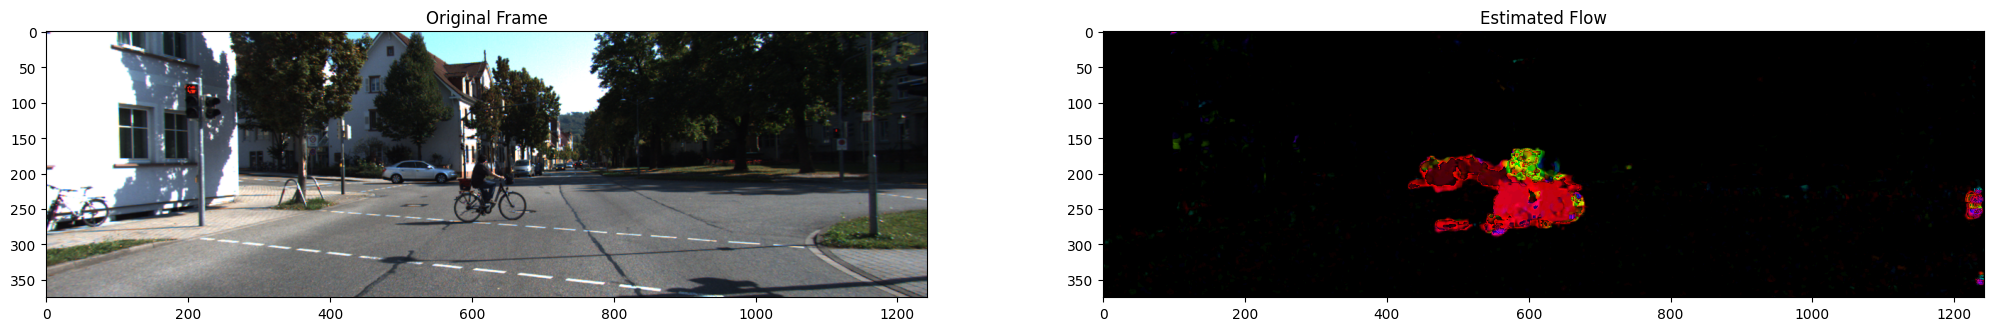

In [192]:
_, ax = plt.subplots(1, 2, figsize=(25, 10))
ax[0].imshow(curr_frame)
ax[0].set_title("Original Frame")

ax[1].imshow(viz_flow(flow)*10)
ax[1].set_title("Estimated Flow");

# Extract Flows in 4 quadrants

In [193]:
motion_thresh = 2

left_motion = (flow[:, :, 0] < -motion_thresh).astype(np.uint8)*255
right_motion = (flow[:, :, 0] > motion_thresh).astype(np.uint8)*255

up_motion = (flow[:, :, 1] < -motion_thresh).astype(np.uint8)*255
down_motion = (flow[:, :, 1] > motion_thresh).astype(np.uint8)*255

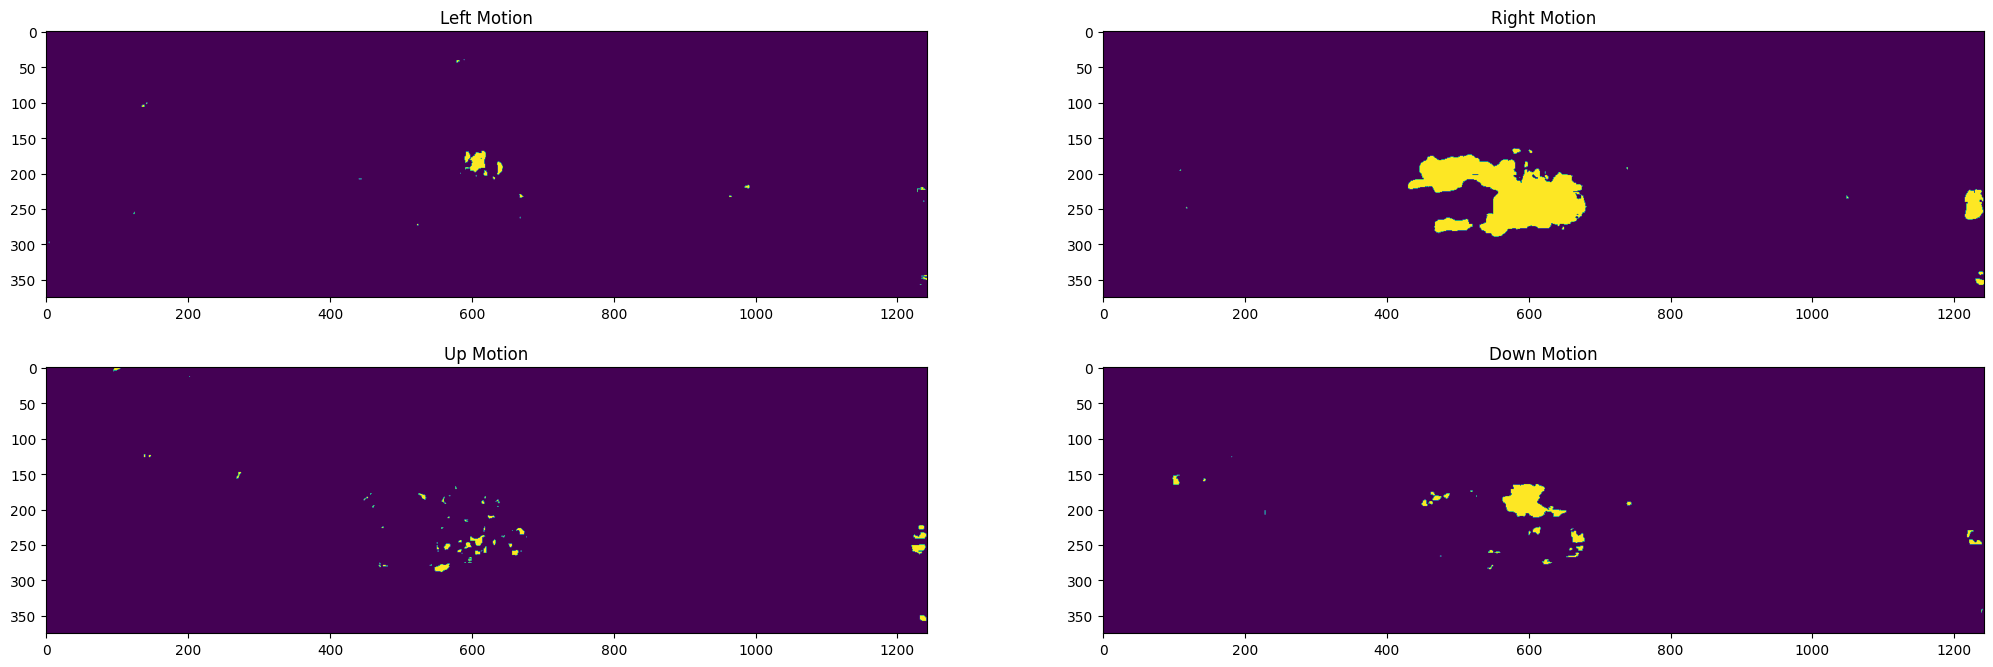

In [194]:
_, ax = plt.subplots(2, 2, figsize=(25, 8))
ax[0][0].imshow(left_motion)
ax[0][0].set_title("Left Motion")

ax[0][1].imshow(right_motion)
ax[0][1].set_title("Right Motion")

ax[1][0].imshow(up_motion)
ax[1][0].set_title("Up Motion")

ax[1][1].imshow(down_motion)
ax[1][1].set_title("Down Motion");

Get all thresholded motions

In [195]:
motion = left_motion | right_motion | up_motion | down_motion

kernel=np.ones((7,7))

motion = cv2.erode(motion, kernel, iterations=1)
motion = cv2.morphologyEx(motion, cv2.MORPH_OPEN, kernel)

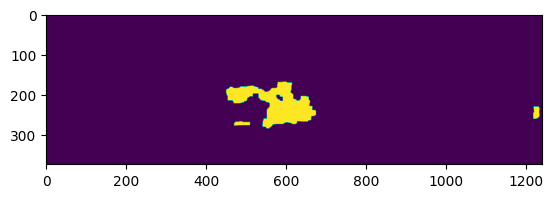

In [196]:
plt.imshow(motion);

Get contours greater than some threshold ad draw them

In [197]:
contours, hierarchy = cv2.findContours(motion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [198]:
def filter_contours(contours, thresh):
    return tuple(filter(lambda x: cv2.contourArea(x) > thresh, contours))

In [199]:
filtered_contours = filter_contours(contours, thresh=400)

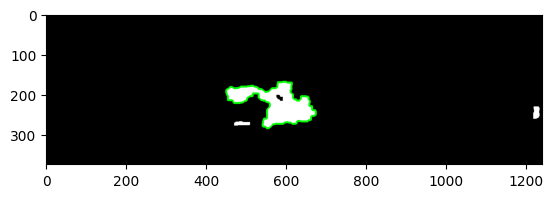

In [200]:
img = motion[:, :, None].repeat(3, axis=-1)
cv2.drawContours(img, filtered_contours, -1, (0,255,0), 3);

plt.imshow(img);

## **Get Detections**

Now that we have drawn the contours, let's get the detection data which will consists of:

- contour array
- contour area
- contour center

In [201]:
detections = {}
area_thresh = 400

for i, c in enumerate(contours):
   area = cv2.contourArea(c)
   if area > area_thresh:
      M = cv2.moments(c)
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])

      detections.update({f"{i}" : [c, area, (cX, cY)]})

## **Make the pipeline**

In [202]:
def get_detections(prev_frame, curr_frame, motion_thresh, area_thresh, kernel):
    # compute dense optical flow
    flow = compute_flow(prev_frame, curr_frame)

    # threshold motion
    left_motion = (flow[:, :, 0] < -motion_thresh).astype(np.uint8)*255
    right_motion = (flow[:, :, 0] > motion_thresh).astype(np.uint8)*255
    up_motion = (flow[:, :, 1] < -motion_thresh).astype(np.uint8)*255
    down_motion = (flow[:, :, 1] > motion_thresh).astype(np.uint8)*255

    motion = left_motion | right_motion | up_motion | down_motion
    motion = cv2.erode(motion, kernel, iterations=1)
    motion = cv2.morphologyEx(motion, cv2.MORPH_OPEN, kernel)

    # find contours
    contours, hierarchy = cv2.findContours(motion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # get detections
    detections = {}
    for i, c in enumerate(contours):
      area = cv2.contourArea(c)
      if area > area_thresh:
          M = cv2.moments(c)
          cX = int(M["m10"] / M["m00"])
          cY = int(M["m01"] / M["m00"])

          detections.update({f"{i}" : [c, area, (cX, cY)]})

    return detections

In [203]:
# set hyperparameters
motion_thresh = 2
area_thresh = 400
kernel = np.ones((7, 7))

In [236]:
# get frames
idx = 25
prev_frame = cv2.cvtColor(cv2.imread(images[idx]), cv2.COLOR_BGR2RGB)
curr_frame = cv2.cvtColor(cv2.imread(images[idx + 1]), cv2.COLOR_BGR2RGB)

In [237]:
detections = get_detections(prev_frame, curr_frame, motion_thresh, area_thresh, kernel)

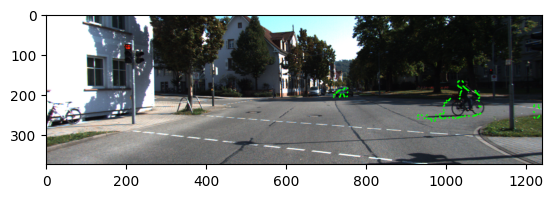

In [238]:
img = curr_frame.copy()
for k,v in detections.items():
    cv2.drawContours(img, v[0], -1, (0,255,0), 3);

plt.imshow(img);